In [1]:
#our necessary imports
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt


In [2]:
random.seed(100)

#compilation of team defensive ratings
team_def_ratings = {
        'OKC': 106.6,
        'ORL': 109.1,
        'LAC': 109.4,
        'BOS': 110.1,
        'HOU': 110.3,
        'MIN': 110.8,
        'GSW': 111.0,
        'CLE': 111.8,
        'MIA': 112.0,
        'DET': 112.5,
        'MEM': 112.6,
        'MIL': 112.7,
        'NYK': 113.3,
        'IND': 113.3,
        'TOR': 113.6,
        'POR': 113.7,
        'LAL': 113.8,
        'CHI': 114.8,
        'ATL': 115.7,
        'BKN': 114.8,
        'DAL': 115.0,
        'DEN': 115.1,
        'SAC': 115.3,
        'BKN': 115.4,
        'CHA': 115.7,
        'SAS': 116.3,
        'PHI': 117.3,
        'PHO': 117.7,
        'WAS': 118.0,
        'NOP': 119.1,
        'UTA': 119.4
    }

In [ ]:
tyrese_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/TyreseSznStats.csv") 
shai_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/ShaiSznStats.csv")  
siakam_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/SiakamSznStats.csv")  
jdub_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/JalenWilliamsSznStats.csv")  
nesmith_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/NesmithSznStats.csv")  
nemhard_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/NemhardSznStats.csv")  
hartenstein_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/iHartSznStats.csv") 
turner_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/TurnerSznStats.csv") 
chet_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/ChetSznStats.csv")
tj_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/TJSznStats.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/visve/Downloads/CS275 Project/Datasets/TJSzn.csv'

In [ ]:
def drtg_adjustment_no_pos(avg_drtg, target_drtg):
    diff = target_drtg - avg_drtg  # Positive = easier defense
    return min(max(1 + (diff * 0.004), 0.85), 1.15)  # 0.4% per point

In [ ]:
def hybrid_hmm_prediction(player_df, team_def_ratings, target_opponent, player_name):

    print(f"HYBRID HMM PREDICTION: {player_name} vs {target_opponent}")
    
    #get the relevant columns, drop missing data
    stat_cols = ['Points', 'Assists', 'Rebounds', 'Steals', 'Blocks', 'Turnovers']
    clean_df = player_df[stat_cols].dropna()
    
    # Check if we have enough data (shouldnt be the case however)
    if len(clean_df) < 10:
        print("Not enough data for HMM (need â‰¥10 games). Using last 5 game average.")
        return clean_df.tail(5).mean().to_dict()
    
    # Standardize data
    scaler = StandardScaler()
    X = scaler.fit_transform(clean_df.values)
    
    #HMM model 
    print("\nHMM Training Diagnostics:")
    model = hmm.GaussianHMM(
        n_components=3,
        covariance_type='diag',
        n_iter=1000,
        tol=1e-6,          
        random_state=100,
        verbose=True        
    )
    
    # Train HMM model and print log likelihood history
    try:
        model.fit(X)
        print(f"Converged after {model.monitor_.iter} iterations")
        print(f"Final Log Likelihood: {model.monitor_.history[-1]:.2f}")

        plt.figure(figsize=(6, 4))
        plt.plot(model.monitor_.history, color='darkred', lw=2)
        plt.xlabel("Iteration")
        plt.ylabel("Log Likelihood")
        plt.title(f"HMM Convergence ({player_name} Game Log)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # If model doesn't converge, catch it and use the last 5 games average
    except Exception as e:
        print(f"HMM Failed to Converge: {str(e)}")
        print("Will now use last 5 games weighted average.")

        #built-in exponential weighted moving average from pandas
        hmm_prediction = clean_df.ewm(span=5).mean().iloc[-1].values
    
    #Predict next state using the last 5 games
    recent_games = clean_df.tail(5)
    X_recent = scaler.transform(recent_games.values)
    
    #viterbi to find most likely state sequence
    try:
        log_probability, state_sequence = model.decode(X_recent, algorithm="viterbi")
        current_state = state_sequence[-1]
    
    #if decoding doesnt work, use the last state
    except:
        state_probs = model.predict_proba(X_recent)
        current_state = np.argmax(state_probs[-1])
    
    # Predict the next state using the HMM model
    hmm_prediction = scaler.inverse_transform([model.means_[current_state]])[0]
    hmm_dict = {}

    #predicted values back to the original data scale
    for i in range(len(stat_cols)):
        hmm_dict[stat_cols[i]] = hmm_prediction[i]
    
    player_df_with_drtg = player_df.copy()

    #the defensive adjustment, uses opponent defensive rating
    player_df_with_drtg['Opponent_DEF_RTG'] = player_df_with_drtg['Opponent'].map(team_def_ratings)
    player_df_with_drtg = player_df_with_drtg.dropna(subset=['Opponent_DEF_RTG'])
    
    #get the target opponent's DRTG
    target_drtg = team_def_ratings[target_opponent]
    avg_drtg = player_df_with_drtg['Opponent_DEF_RTG'].mean()
    
    # use linear adjustment function from earlier to calculate adjustment factor
    def_factor = drtg_adjustment_no_pos(avg_drtg, target_drtg)
    
    #test to see if defensive rating is being applied
    print(f"\nDefense Adjustment:")
    print(f"  Avg DRTG Faced: {avg_drtg:.1f}")
    print(f"  Target DRTG: {target_drtg:.1f}")
    print(f"  Adjustment Factor: {def_factor:.3f}")
    
    #adjust offensive stats more, since more affected by better defense
    final_prediction = hmm_dict.copy()
    for stat in ['Points', 'Assists']:  
        final_prediction[stat] *= def_factor
    
    # Round outputs
    for k, v in final_prediction.items():
        final_prediction[k] = int(round(v))
    
    # Print final prediction
    print(f"\nFinal Prediction:")
    for stat, val in final_prediction.items():
        print(f"  {stat}: {val}")
    
    return final_prediction


In [ ]:

def traditional_hmm_no_drtg(player_df, target_opponent, player_name):
   
    print(f"\nTRADITIONAL HMM: {player_name} (No DRTG)")
    
    #get the relevant columns, drop missing data
    stat_cols = ['Points', 'Assists', 'Rebounds', 'Steals', 'Blocks', 'Turnovers']
    clean_df = player_df[stat_cols].dropna()
    
    # standard scaler
    scaler = StandardScaler()
    X = scaler.fit_transform(clean_df.values)

    #HMM model
    model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=100)
    model.fit(X)
    
    # Predict next game using the last 5 games
    recent_games = clean_df.tail(5)
    X_recent = scaler.transform(recent_games.values)
    
    #viterbi algorithm to find most likely state sequence
    try:
        log_probability, state_sequence = model.decode(X_recent, algorithm="viterbi")
        current_state = state_sequence[-1]
        next_state = np.argmax(model.transmat_[current_state])

    # If decoding doesn't work, use the last state
    except:
        state_probs = model.predict(X_recent)
        current_state = state_probs[-1]
        next_state = current_state
    
    # Predict the next state usinghe HMM model
    prediction = scaler.inverse_transform([model.means_[next_state]])[0]
    
    #round output, and print results
    print(f"Traditional HMM Prediction:")
    result = {}

    for i in range(len(stat_cols)):
        stat = stat_cols[i]
        value = prediction[i]
        result[stat] = value
        print(f"  {stat}: {int(round(value))}")
    
    return result


In [ ]:

# Comparison function
def compare_all_approaches(player_df, team_def_ratings, target_opponent, player_name):
   
    print(f"\nCOMPARISON: {player_name} vs {target_opponent}")
    
    #Hybrid HMM
    hybrid_result = hybrid_hmm_prediction(player_df, team_def_ratings, target_opponent, player_name)
    
    #Traditional HMM
    traditional_result = traditional_hmm_no_drtg(player_df, target_opponent, player_name)
    
    # simple recent average method with defense adjustment after
    stat_cols = ['Points', 'Assists', 'Rebounds', 'Steals', 'Blocks', 'Turnovers']
    recent_avg = player_df[stat_cols].tail(10).mean()
    
    player_df_drtg = player_df.copy()
    player_df_drtg['Opponent_DEF_RTG'] = player_df_drtg['Opponent'].map(team_def_ratings)
    player_df_drtg = player_df_drtg.dropna(subset=['Opponent_DEF_RTG'])
    
    # Get the target opponent's DRTG
    target_drtg = team_def_ratings[target_opponent]
    avg_drtg = player_df_drtg['Opponent_DEF_RTG'].mean()
    def_factor = avg_drtg / target_drtg
    
    # Apply defense adjustment to recent average
    simple_result = recent_avg.copy()
    for stat in ['Points', 'Assists']:
        simple_result[stat] *= def_factor
    
    #final comparisons
    print(f"\nFINAL COMPARISON:")
    print(f"{'Stat':<10} {'Hybrid':<8} {'Traditional':<11} {'Simple':<8} {'Range'}")
    
    for stat in stat_cols:
        # Round values
        hybrid_val = int(round(hybrid_result[stat]))
        trad_val = int(round(traditional_result[stat]))
        simple_val = int(round(simple_result[stat]))
        
        #range to see how different the method outputs are
        values = [hybrid_val, trad_val, simple_val]
        range_val = max(values) - min(values)
        
        # Print results and round to nearest integer
        print(f"{stat:<10} {hybrid_val:<8} {trad_val:<11} {simple_val:<8} {range_val}")
    
    return hybrid_result, traditional_result, simple_result.to_dict()


COMPARISON: Tyrese Haliburton vs OKC
HYBRID HMM PREDICTION: Tyrese Haliburton vs OKC

HMM Training Diagnostics:
Converged after 66 iterations
Final Log Likelihood: -558.07


         1    -782.33224972             +nan
         2    -726.09014497     +56.24210475
         3    -722.80472014      +3.28542482
         4    -721.70245055      +1.10226959
         5    -720.30834469      +1.39410586
         6    -715.70588616      +4.60245853
         7    -709.73375474      +5.97213142
         8    -704.61107405      +5.12268069
         9    -689.48118420     +15.12988985
        10    -620.45313240     +69.02805180
        11    -561.07760827     +59.37552413
        12    -558.74600126      +2.33160701
        13    -558.36651579      +0.37948548
        14    -558.20472404      +0.16179174
        15    -558.12516693      +0.07955711
        16    -558.09752003      +0.02764690
        17    -558.08886755      +0.00865248
        18    -558.08537489      +0.00349266
        19    -558.08334810      +0.00202679
        20    -558.08186088      +0.00148722
        21    -558.08065395      +0.00120693
        22    -558.07963738      +0.00101657
        23

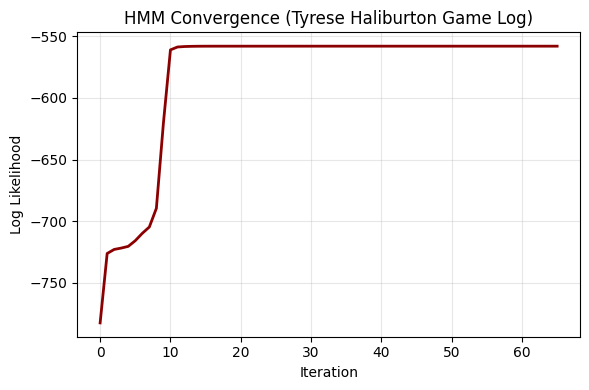


Defense Adjustment:
  Avg DRTG Faced: 113.7
  Target DRTG: 106.6
  Adjustment Factor: 0.972

Final Prediction:
  Points: 18
  Assists: 9
  Rebounds: 4
  Steals: 2
  Blocks: 2
  Turnovers: 2

TRADITIONAL HMM: Tyrese Haliburton (No DRTG)
Traditional HMM Prediction:
  Points: 19
  Assists: 9
  Rebounds: 4
  Steals: 2
  Blocks: 2
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     18       19          20       2
Assists    9        9           9        0
Rebounds   4        4           6        2
Steals     2        2           2        0
Blocks     2        2           0        2
Turnovers  2        2           2        0


In [ ]:
# Test the hybrid approach
hybrid_result, traditional_result, simple_result = compare_all_approaches(
    tyrese_df, team_def_ratings, "OKC", "Tyrese Haliburton"
)

         1    -798.88986404             +nan
         2    -764.07595488     +34.81390916
         3    -760.65875450      +3.41720038
         4    -757.01169755      +3.64705695
         5    -743.10093670     +13.91076085
         6    -702.96203900     +40.13889770
         7    -675.14522316     +27.81681583
         8    -646.65107498     +28.49414819
         9    -624.12421704     +22.52685794
        10    -618.85438445      +5.26983259
        11    -618.13064286      +0.72374159
        12    -617.39246112      +0.73818174
        13    -616.81801846      +0.57444267
        14    -616.59179887      +0.22621959
        15    -616.53880665      +0.05299222
        16    -616.52794690      +0.01085975
        17    -616.52521480      +0.00273210
        18    -616.52421937      +0.00099543
        19    -616.52374470      +0.00047467
        20    -616.52349197      +0.00025273
        21    -616.52335301      +0.00013895
        22    -616.52327624      +0.00007677
        23


COMPARISON: Shai-Gilgeous Alexander vs IND
HYBRID HMM PREDICTION: Shai-Gilgeous Alexander vs IND

HMM Training Diagnostics:
Converged after 29 iterations
Final Log Likelihood: -616.52


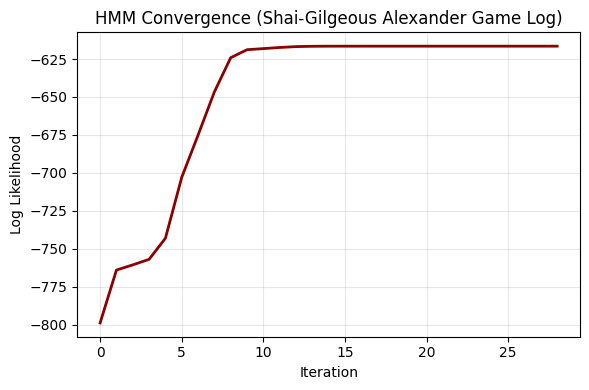


Defense Adjustment:
  Avg DRTG Faced: 113.6
  Target DRTG: 113.3
  Adjustment Factor: 0.999

Final Prediction:
  Points: 31
  Assists: 7
  Rebounds: 5
  Steals: 2
  Blocks: 0
  Turnovers: 2

TRADITIONAL HMM: Shai-Gilgeous Alexander (No DRTG)
Traditional HMM Prediction:
  Points: 28
  Assists: 7
  Rebounds: 3
  Steals: 1
  Blocks: 2
  Turnovers: 3

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     31       28          30       3
Assists    7        7           7        0
Rebounds   5        3           6        3
Steals     2        1           2        1
Blocks     0        2           0        2
Turnovers  2        3           2        1


In [ ]:
hybrid_result1, traditional_result1, simple_result1 = compare_all_approaches(
    shai_df, team_def_ratings, "IND", "Shai-Gilgeous Alexander"
)


COMPARISON: Pascal Siakam vs OKC
HYBRID HMM PREDICTION: Pascal Siakam vs OKC

HMM Training Diagnostics:
Converged after 22 iterations
Final Log Likelihood: -475.95


         1    -808.28212007             +nan
         2    -780.53733082     +27.74478925
         3    -772.95918158      +7.57814923
         4    -765.21162891      +7.74755268
         5    -761.30465994      +3.90696897
         6    -759.82933004      +1.47532990
         7    -758.79146498      +1.03786506
         8    -757.48015539      +1.31130959
         9    -754.82974514      +2.65041025
        10    -745.68466598      +9.14507917
        11    -676.50503990     +69.17962608
        12    -580.08162673     +96.42341316
        13    -549.49588652     +30.58574022
        14    -534.71450961     +14.78137690
        15    -486.24656407     +48.46794554
        16    -476.76841155      +9.47815253
        17    -475.96996689      +0.79844466
        18    -475.95084661      +0.01912028
        19    -475.95006101      +0.00078560
        20    -475.95002681      +0.00003420
        21    -475.95002531      +0.00000150
        22    -475.95002524      +0.00000007


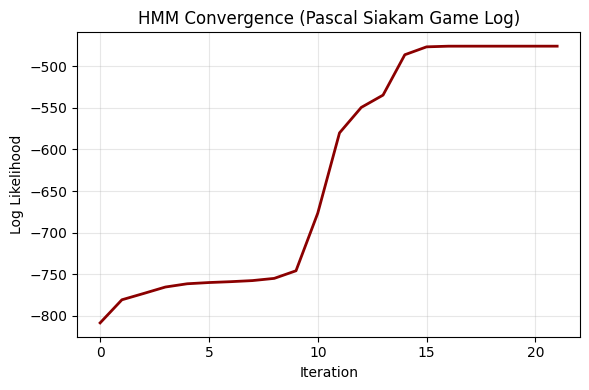


Defense Adjustment:
  Avg DRTG Faced: 113.7
  Target DRTG: 106.6
  Adjustment Factor: 0.972

Final Prediction:
  Points: 22
  Assists: 3
  Rebounds: 7
  Steals: 1
  Blocks: 2
  Turnovers: 2

TRADITIONAL HMM: Pascal Siakam (No DRTG)
Traditional HMM Prediction:
  Points: 20
  Assists: 3
  Rebounds: 7
  Steals: 1
  Blocks: 0
  Turnovers: 1

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     22       20          24       4
Assists    3        3           4        1
Rebounds   7        7           5        2
Steals     1        1           1        0
Blocks     2        0           0        2
Turnovers  2        1           1        1


In [ ]:
hybrid_result2, traditional_result2, simple_resul2 = compare_all_approaches(
    siakam_df, team_def_ratings, "OKC", "Pascal Siakam"
)


COMPARISON: Jalen Williams vs IND
HYBRID HMM PREDICTION: Jalen Williams vs IND

HMM Training Diagnostics:
Converged after 62 iterations
Final Log Likelihood: -445.29


         1    -752.33707840             +nan
         2    -719.33483984     +33.00223856
         3    -714.73248071      +4.60235913
         4    -710.23463683      +4.49784388
         5    -705.89720045      +4.33743638
         6    -703.94970691      +1.94749354
         7    -702.94426624      +1.00544067
         8    -702.06887836      +0.87538788
         9    -701.05113392      +1.01774444
        10    -700.06825385      +0.98288007
        11    -699.36416269      +0.70409116
        12    -698.89073790      +0.47342480
        13    -698.55147024      +0.33926766
        14    -698.30620549      +0.24526475
        15    -698.13737416      +0.16883133
        16    -698.02364873      +0.11372542
        17    -697.94403827      +0.07961047
        18    -697.88499568      +0.05904259
        19    -697.83910023      +0.04589545
        20    -697.80221848      +0.03688175
        21    -697.77185528      +0.03036321
        22    -697.74637691      +0.02547836
        23

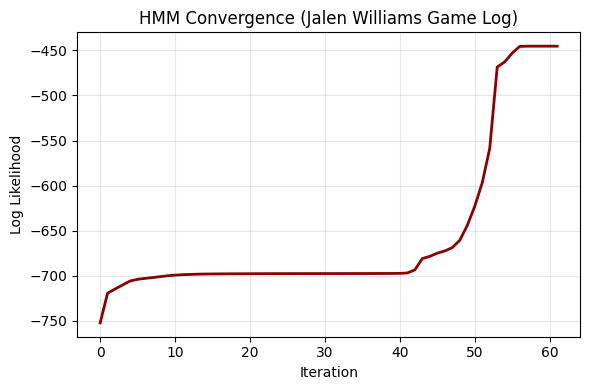


Defense Adjustment:
  Avg DRTG Faced: 113.7
  Target DRTG: 113.3
  Adjustment Factor: 0.998

Final Prediction:
  Points: 22
  Assists: 6
  Rebounds: 5
  Steals: 2
  Blocks: 1
  Turnovers: 2

TRADITIONAL HMM: Jalen Williams (No DRTG)
Traditional HMM Prediction:
  Points: 21
  Assists: 5
  Rebounds: 5
  Steals: 1
  Blocks: 0
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     22       21          20       2
Assists    6        5           5        1
Rebounds   5        5           6        1
Steals     2        1           2        1
Blocks     1        0           0        1
Turnovers  2        2           2        0


In [ ]:
hybrid_result3, traditional_result3, simple_result3 = compare_all_approaches(
    jdub_df, team_def_ratings, "IND", "Jalen Williams"
)


COMPARISON: Aaron Nesmith vs OKC
HYBRID HMM PREDICTION: Aaron Nesmith vs OKC

HMM Training Diagnostics:
Converged after 42 iterations
Final Log Likelihood: -397.04


         1    -534.12441202             +nan
         2    -506.54118660     +27.58322542
         3    -499.13676104      +7.40442556
         4    -495.71129321      +3.42546782
         5    -493.44527957      +2.26601364
         6    -490.32980477      +3.11547480
         7    -486.52855602      +3.80124876
         8    -478.32721948      +8.20133653
         9    -427.38653458     +50.94068490
        10    -408.41007902     +18.97645556
        11    -400.12944333      +8.28063569
        12    -398.95982931      +1.16961402
        13    -398.85226474      +0.10756457
        14    -398.80262082      +0.04964392
        15    -398.76119206      +0.04142876
        16    -398.70175505      +0.05943701
        17    -398.54546670      +0.15628835
        18    -398.06742548      +0.47804122
        19    -397.50819166      +0.55923382
        20    -397.36444047      +0.14375120
        21    -397.27055932      +0.09388115
        22    -397.18716116      +0.08339816
        23

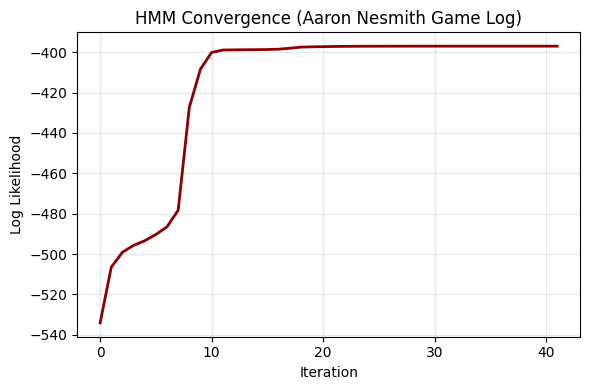


Defense Adjustment:
  Avg DRTG Faced: 113.8
  Target DRTG: 106.6
  Adjustment Factor: 0.971

Final Prediction:
  Points: 13
  Assists: 1
  Rebounds: 5
  Steals: 1
  Blocks: 1
  Turnovers: 0

TRADITIONAL HMM: Aaron Nesmith (No DRTG)
Traditional HMM Prediction:
  Points: 9
  Assists: 1
  Rebounds: 3
  Steals: 1
  Blocks: 0
  Turnovers: 1

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     13       9           14       5
Assists    1        1           1        0
Rebounds   5        3           5        2
Steals     1        1           1        0
Blocks     1        0           1        1
Turnovers  0        1           1        1


In [ ]:
hybrid4, traditional4, simple4 = compare_all_approaches(
    nesmith_df, team_def_ratings, "OKC", "Aaron Nesmith"
)



COMPARISON: Andrew Nembhard vs OKC
HYBRID HMM PREDICTION: Andrew Nembhard vs OKC

HMM Training Diagnostics:
Converged after 77 iterations
Final Log Likelihood: -373.76


         1    -714.44964165             +nan
         2    -618.76048242     +95.68915923
         3    -507.93740251    +110.82307991
         4    -391.28265334    +116.65474917
         5    -389.69841886      +1.58423448
         6    -388.54684132      +1.15157753
         7    -387.67750242      +0.86933890
         8    -387.11489255      +0.56260987
         9    -386.79403248      +0.32086007
        10    -386.53750751      +0.25652498
        11    -386.25247168      +0.28503583
        12    -385.87111126      +0.38136042
        13    -385.15860219      +0.71250906
        14    -382.11788940      +3.04071280
        15    -375.73348326      +6.38440613
        16    -375.02902459      +0.70445867
        17    -374.88969052      +0.13933407
        18    -374.79241752      +0.09727300
        19    -374.71293390      +0.07948362
        20    -374.64320315      +0.06973075
        21    -374.57914059      +0.06406256
        22    -374.51851672      +0.06062387
        23

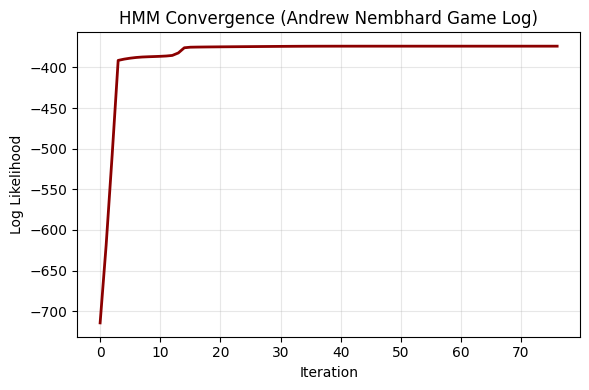


Defense Adjustment:
  Avg DRTG Faced: 113.6
  Target DRTG: 106.6
  Adjustment Factor: 0.972

Final Prediction:
  Points: 13
  Assists: 6
  Rebounds: 5
  Steals: 2
  Blocks: 1
  Turnovers: 2

TRADITIONAL HMM: Andrew Nembhard (No DRTG)
Traditional HMM Prediction:
  Points: 11
  Assists: 5
  Rebounds: 3
  Steals: 1
  Blocks: 0
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     13       11          11       2
Assists    6        5           5        1
Rebounds   5        3           4        2
Steals     2        1           2        1
Blocks     1        0           0        1
Turnovers  2        2           2        0


In [ ]:
hybrid6, traditional6, simple6 = compare_all_approaches(
    nemhard_df, team_def_ratings, "OKC", "Andrew Nembhard"
)


COMPARISON: Isaiah Hartenstein vs IND
HYBRID HMM PREDICTION: Isaiah Hartenstein vs IND

HMM Training Diagnostics:
Converged after 74 iterations
Final Log Likelihood: -566.54


         1    -634.82027464             +nan
         2    -590.06749318     +44.75278146
         3    -577.03876406     +13.02872911
         4    -573.78052780      +3.25823627
         5    -572.52244081      +1.25808699
         6    -571.70524716      +0.81719364
         7    -571.20854893      +0.49669823
         8    -570.96521169      +0.24333723
         9    -570.86655174      +0.09865996
        10    -570.83176719      +0.03478455
        11    -570.82017414      +0.01159305
        12    -570.81581335      +0.00436079
        13    -570.81321394      +0.00259941
        14    -570.81045946      +0.00275448
        15    -570.80659460      +0.00386486
        16    -570.80069909      +0.00589551
        17    -570.79143453      +0.00926456
        18    -570.77660552      +0.01482900
        19    -570.75252187      +0.02408365
        20    -570.71304417      +0.03947771
        21    -570.64840889      +0.06463528
        22    -570.54456637      +0.10384252
        23

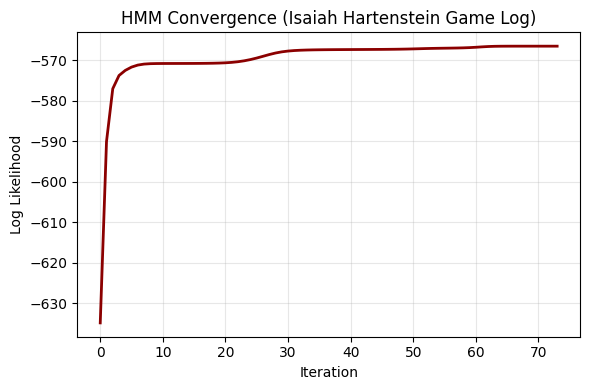


Defense Adjustment:
  Avg DRTG Faced: 113.5
  Target DRTG: 113.3
  Adjustment Factor: 0.999

Final Prediction:
  Points: 9
  Assists: 4
  Rebounds: 10
  Steals: 2
  Blocks: 2
  Turnovers: 2

TRADITIONAL HMM: Isaiah Hartenstein (No DRTG)
Traditional HMM Prediction:
  Points: 13
  Assists: 4
  Rebounds: 11
  Steals: 0
  Blocks: 1
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     9        13          9        4
Assists    4        4           1        3
Rebounds   10       11          7        4
Steals     2        0           1        2
Blocks     2        1           1        1
Turnovers  2        2           1        1


In [ ]:
hybrid7, traditional7, simple7 = compare_all_approaches(
    hartenstein_df, team_def_ratings, "IND", "Isaiah Hartenstein"
)



COMPARISON: Myles Turner vs OKC
HYBRID HMM PREDICTION: Myles Turner vs OKC

HMM Training Diagnostics:
Converged after 31 iterations
Final Log Likelihood: -709.43


         1    -777.79453885             +nan
         2    -728.82178050     +48.97275834
         3    -720.73993029      +8.08185021
         4    -717.62233338      +3.11759691
         5    -715.53494514      +2.08738824
         6    -714.05607035      +1.47887478
         7    -713.08415065      +0.97191970
         8    -712.41618857      +0.66796208
         9    -711.60332217      +0.81286640
        10    -710.43400615      +1.16931602
        11    -709.76834812      +0.66565803
        12    -709.54315736      +0.22519076
        13    -709.47228351      +0.07087385
        14    -709.44762244      +0.02466107
        15    -709.43758431      +0.01003814
        16    -709.43299469      +0.00458961
        17    -709.43073340      +0.00226129
        18    -709.42956449      +0.00116891
        19    -709.42894074      +0.00062374
        20    -709.42860058      +0.00034016
        21    -709.42841219      +0.00018839
        22    -709.42830669      +0.00010550
        23

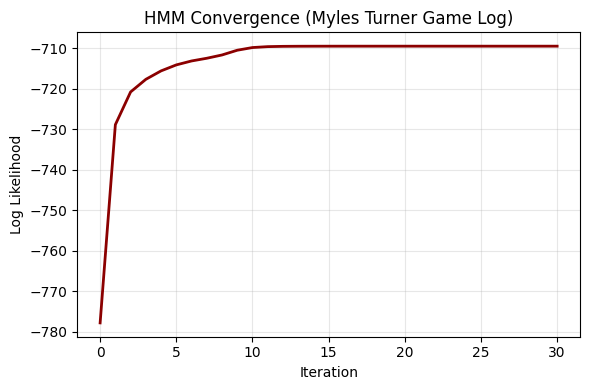


Defense Adjustment:
  Avg DRTG Faced: 113.6
  Target DRTG: 106.6
  Adjustment Factor: 0.972

Final Prediction:
  Points: 16
  Assists: 2
  Rebounds: 6
  Steals: 1
  Blocks: 2
  Turnovers: 1

TRADITIONAL HMM: Myles Turner (No DRTG)
Traditional HMM Prediction:
  Points: 16
  Assists: 2
  Rebounds: 6
  Steals: 1
  Blocks: 2
  Turnovers: 1

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     16       16          16       0
Assists    2        2           1        1
Rebounds   6        6           4        2
Steals     1        1           0        1
Blocks     2        2           2        0
Turnovers  1        1           2        1


In [ ]:
hybrid8, traditional8, simple8 = compare_all_approaches(
    turner_df, team_def_ratings, "OKC", "Myles Turner"
)

In [ ]:
hybrid9, traditional9, simple9 = compare_all_approaches(
    chet_df, team_def_ratings, "IND", "Chet Holmgren"
)

In [ ]:
hybrid10, traditional10, simple10 = compare_all_approaches(
    tj_df, team_def_ratings, "OKC", "T.J. McConnell"
)
